## Data Info

This is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin Alpha. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin Alpha rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. This is the first explicit weighted signed directed network available for research.

|Dataset | statistics|
|--------|-----------|
|Nodes 	|3,783|
|Edges 	|24,186|
|Range of edge weight |	-10 to +10|
|Percentage of positive edges |	93%|


Data format

Each line has one rating with the following format:

SOURCE, TARGET, RATING, TIME

where

    SOURCE: node id of source, i.e., rater
    TARGET: node id of target, i.e., ratee
    RATING: the source's rating for the target, ranging from -10 to +10 in steps of 1
    TIME: the time of the rating, measured as seconds since Epoch. (This can be converted to human readable data easily as described here)



## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import networkx as nx
from matplotlib.pyplot import figure
import math

In [2]:
df = pd.read_csv('soc-sign-bitcoinalpha.csv', header = None)

In [3]:
df = df.rename(columns={0:'source',1:'target',2:'rating',3:'time'})

In [4]:
df['date'] = df['time'].apply(lambda x: datetime.fromtimestamp(x))

In [5]:
G = nx.from_pandas_edgelist(df=df, source = 'source', target='target', edge_attr=['rating','time','date'])

This graph is not fully connected

In [6]:
print(nx.is_connected(G))

False


In [7]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3783
Number of edges: 14124
Average degree:   7.4671


Viewing the graph shows that there is a large connected component and several small conponents.

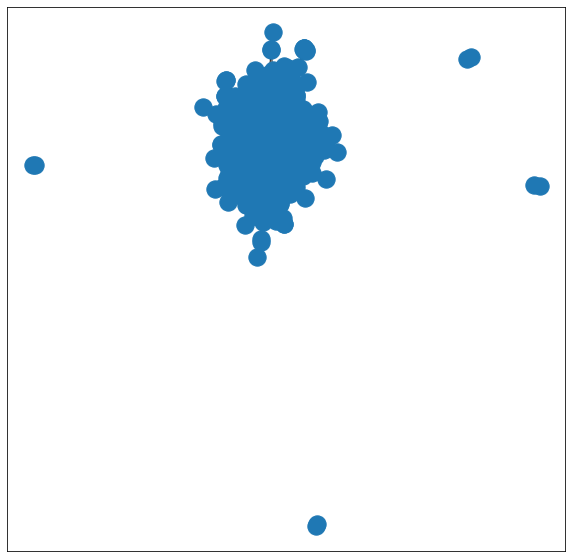

In [8]:
figure(figsize=(10, 10))
nx.draw_networkx(G, with_labels = False)

This will isolate the largest connected graph

In [9]:
components = nx.connected_components(G)

In [10]:
largest_component = max(components, key = len)

In [11]:
subgraph = G.subgraph(largest_component)

In [12]:
print(nx.info(subgraph))

Name: 
Type: Graph
Number of nodes: 3775
Number of edges: 14120
Average degree:   7.4808


## Question 1

I used the edge list to determine which edge weight had bee updated most recently. Looking at the dates the most recent connection to be updated is the one that runs to the target node 98 through the node 3451 and the one that runs to node 3451 through node 15.

In [13]:
df.sort_values('date', ascending=False).head()

,source,target,rating,time,date
13594,3451,98,5,1453438800,2016-01-22
5382,15,3451,1,1453438800,2016-01-22
14393,114,7370,-1,1453006800,2016-01-17
21814,604,1202,1,1452920400,2016-01-16
19152,281,3450,1,1452920400,2016-01-16


## Question 3

This finds all of the paths to the target node and returns a dictionary.  The default method for nx.shortest_path is Dijkstra's algorithm. The number of paths in this dictionary is the same as the number of nodes in the largest connected component which indicates that this network is connected. In other words, there is a shortest path to the target node from every node in the largest connected component.

In [14]:
paths = nx.shortest_path(G,target=98)

In [15]:
len(paths)

3775

In [16]:
len(subgraph)

3775

In [17]:
nx.is_connected(subgraph)

True

The same can be done targeting node 3451

In [18]:
paths = nx.shortest_path(G,target=3451)

In [19]:
len(paths)

3775

## Question 3

For the network that terminates at node 98:

In [20]:
paths = nx.shortest_path(G,target=98)

In [21]:
max_length = 0
for path in paths:
    if len(paths[path]) > max_length:
        max_length = len(paths[path])

In [22]:
max_length

7

For the network that terminates at node 3451:

In [23]:
paths = nx.shortest_path(G,target=3451)

In [24]:
max_length = 0
for path in paths:
    if len(paths[path]) > max_length:
        max_length = len(paths[path])

In [25]:
max_length

8

## Question 4

Adding 10 to each rating

In [26]:
df4 = df

In [27]:
df4['rating'] += 10

In [28]:
df4.describe()

,source,target,rating,time
count,24186.000000,24186.000000,24186.000000,2.418600e+04
mean,864.029314,1051.093815,11.463946,1.347099e+09
std,1592.085638,1871.765504,2.903656,3.397039e+07
min,1.000000,1.000000,0.000000,1.289192e+09
25%,58.000000,66.000000,11.000000,1.312690e+09
50%,238.000000,279.000000,11.000000,1.345435e+09
75%,898.000000,1068.000000,12.000000,1.369454e+09
max,7604.000000,7604.000000,20.000000,1.453439e+09


Making a new graph:

In [29]:
G4 = nx.from_pandas_edgelist(df=df4, source='source', target='target', edge_attr='rating')

Finding all shortest paths from the source node based on the weight 'rating'. 

In [30]:
paths = nx.shortest_path(G4, source=1, weight='rating')

Since node one is included in the largest connected component, the number of shortest paths is equal to the number of nodes in the component.

In [31]:
len(paths)

3775

The following will compute the average weight for each path and return the paths that have an average weight greater than or equal to 10.

In [32]:
num_paths = 0
pos_path = {}
for path in paths:
    temp = paths[path]
    ratings = []
    for i in range(len(temp)-1):
        ratings.append(G4[temp[i]][temp[i+1]]['rating'])
        
    if len(ratings) !=0:
        avg_rating = sum(ratings)/len(ratings)
    else:
        avg_rating = 0
        
    if avg_rating >= 10:
        num_paths += 1
        pos_path[path] = [temp,avg_rating]

Example of the output:

In [33]:
pos_path[3053]

[[1, 18, 3053], 12.5]

The length of the output gives the total number of paths that satisfy this criteria.

In [34]:
len(pos_path)

696

Running the same pipeline on a different node to compare the output (node 3053).

In [35]:
paths = nx.shortest_path(G4, source=3053, weight='rating')

There are the same number of paths initially.

In [36]:
len(paths)

3775

In [37]:
num_paths = 0
pos_path = {}
for path in paths:
    temp = paths[path]
    ratings = []
    for i in range(len(temp)-1):
        ratings.append(G4[temp[i]][temp[i+1]]['rating'])
        
    if len(ratings) !=0:
        avg_rating = sum(ratings)/len(ratings)
    else:
        avg_rating = 0
        
    if avg_rating >= 10:
        num_paths += 1
        pos_path[path] = [temp,avg_rating]

The output for the path to one returns a similar value as above.

In [38]:
pos_path[1]

[[3053, 18, 1], 12.5]

The length of the output gives the total number of paths that satisfy this criteria. There are many more paths that match this criteria for this node.

In [39]:
len(pos_path)

947

Running the same pipeline on a different node to compare the output (node: 700).

In [40]:
paths = nx.shortest_path(G4, source=700, weight='rating')

There are the same number of paths initially.

In [41]:
len(paths)

3775

In [42]:
num_paths = 0
pos_path = {}
for path in paths:
    temp = paths[path]
    ratings = []
    for i in range(len(temp)-1):
        ratings.append(G4[temp[i]][temp[i+1]]['rating'])
        
    if len(ratings) !=0:
        avg_rating = sum(ratings)/len(ratings)
    else:
        avg_rating = 0
        
    if avg_rating >= 10:
        num_paths += 1
        pos_path[path] = [temp,avg_rating]

The paths to node one from node 700 did not meet the criteria so the path to node 410 is used as an example.

In [43]:
pos_path[410]

[[700, 800, 410], 12.0]

The length of the output gives the total number of paths that satisfy this criteria. For this node, many fewer paths met the criteria.

In [44]:
len(pos_path)

268

## Question 5

In [45]:
paths = nx.shortest_path(G4, source=1, weight='rating')

Since node one is included in the largest connected component, the number of shortest paths is equal to the number of nodes in the component.

In [46]:
len(paths)

3775

The following will compute the average weight for each path and return the paths that have an average weight greater than or equal to 10.

In [47]:
num_paths = 0
pos_path = {}
for path in paths:
    temp = paths[path]
    ratings = []
    for i in range(len(temp)-1):
        ratings.append(G4[temp[i]][temp[i+1]]['rating'])
        
    if len(ratings) !=0:
        mult = 1
        n = len(ratings)
        for i in range(n):
            mult *= ratings[i]
        geom_mean = mult**(1/n)
    else:
        geom_mean = 0
        
    if geom_mean >= 10:
        num_paths += 1
        pos_path[path] = [temp,geom_mean]

Example of the output:

In [48]:
pos_path[3053]

[[1, 18, 3053], 12.409673645990857]

The length of the output gives the total number of paths that satisfy this criteria. This criteria returned less paths than the algebraic mean.

In [49]:
len(pos_path)

690

Running the same pipeline on a different node to compare the output (node 3053).

In [50]:
paths = nx.shortest_path(G4, source=3053, weight='rating')

There are the same number of paths initially.

In [51]:
len(paths)

3775

In [52]:
num_paths = 0
pos_path = {}
for path in paths:
    temp = paths[path]
    ratings = []
    for i in range(len(temp)-1):
        ratings.append(G4[temp[i]][temp[i+1]]['rating'])
        
    if len(ratings) !=0:
        mult = 1
        n = len(ratings)
        for i in range(n):
            mult *= ratings[i]
        geom_mean = mult**(1/n)
    else:
        geom_mean = 0
        
    if geom_mean >= 10:
        num_paths += 1
        pos_path[path] = [temp,geom_mean]

The output for the path to one returns a similar value as above.

In [53]:
pos_path[1]

[[3053, 18, 1], 12.409673645990857]

The length of the output gives the total number of paths that satisfy this criteria. Again, this criteria returned less paths than the algebraic mean but there are still many more paths that match this criteria for this node.

In [54]:
len(pos_path)

937

Running the same pipeline on a different node to compare the output (node: 700).

In [55]:
paths = nx.shortest_path(G4, source=700, weight='rating')

There are the same number of paths initially.

In [56]:
len(paths)

3775

In [57]:
num_paths = 0
pos_path = {}
for path in paths:
    temp = paths[path]
    ratings = []
    for i in range(len(temp)-1):
        ratings.append(G4[temp[i]][temp[i+1]]['rating'])
        
    if len(ratings) !=0:
        mult = 1
        n = len(ratings)
        for i in range(n):
            mult *= ratings[i]
        geom_mean = mult**(1/n)
    else:
        geom_mean = 0
        
    if geom_mean >= 10:
        num_paths += 1
        pos_path[path] = [temp,geom_mean]

The paths to node one from node 700 did not meet the criteria so the path to node 410 is used as an example.

In [58]:
pos_path[410]

[[700, 800, 410], 12.0]

The length of the output gives the total number of paths that satisfy this criteria. For this node, many fewer paths met the criteria.

In [59]:
len(pos_path)

253